# Analysis file for Ariane quantitative runs
gets data from .nc file into basic plot<br>
based on code from https://github.com/SalishSeaCast/analysis-susan/blob/master/notebooks/Ariane/FluxRobertsBankApr2015-New.ipynb

In [1]:
import cmocean.cm as cm
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

import scipy.interpolate as interp

%matplotlib inline

### get grid info

In [2]:
mymesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask201702.nc')
depthf = interp.interp1d(mymesh.z, mymesh.gdept_1d)

In [3]:
def draw_patches(fmask, lonW, lonE, t_dist, t_depths): #draw ground part of cross section
    topo = []
    for i in range(lonW,lonE):
        for j in range(39):
            if fmask[j, i] == 0:
                rect = Rectangle((t_dist[i], t_depths[j]), t_dist[i+1]-t_dist[i], t_depths[j+1]-t_depths[j])
                topo.append(rect)
    pc = PatchCollection(topo, facecolors='burlywood', edgecolors='burlywood', zorder=3)
    return(pc)

In [4]:
def tranCS(section, lonW, lonE, figrid, maxdepth, ax, title):
    igrid = figrid-1
    fmask = mymesh.fmask[0, :, igrid]
    tmask = mymesh.tmask[0]
    nav_lon = mymesh.nav_lon[igrid]
    time = mydata.init_t[-1]
    
    lons = mydata.final_lon[(mydata.final_section==section)]
    lats = mydata.final_lat[(mydata.final_section==section)]
    
    t_lons = mymesh.glamt[0, igrid]
    m2lon = ((t_lons[lonE]-t_lons[lonW])/(mymesh.e1t[0, igrid, lonW:lonE].sum()))
    t_dist = t_lons/m2lon
    t_depths = mymesh.gdept_1d[0,:]
    
    xs, ys = np.meshgrid(np.array(t_dist), np.array(t_depths))
    
    dist = lons/m2lon
    depths = depthf(mydata.final_z[(mydata.final_section==section)]-1.)[0]
    transports = mydata.final_transp[(mydata.final_section==section)]/time
    
    vmax = .1/sum(transports)
    
    c, xedge, yedge, im = ax.hist2d(dist, 
                            depths,
                            weights=transports,
                            bins=[np.array(t_dist[lonW:lonE]), t_depths], cmap=cm.matter, vmax = vmax, density=True, zorder=1) 
    
    salinity = 0.5*(np.ma.array(xr.open_dataset(salfile).vosaline[0, :, igrid],
            mask=1-tmask[:, igrid]) +
            np.ma.array(xr.open_dataset(salfile).vosaline[0, :, igrid+1],
            mask=1-tmask[:, igrid+1]))
    CS = ax.contour(xs, ys, salinity,  [29, 30, 30.2, 30.4, 30.6, 30.8, 31, 31.2, 31.4], colors='g', zorder = 2)
    
    pc = draw_patches(fmask, lonW, lonE, np.array(t_dist), np.array(t_depths))
    ax.add_collection(pc)
    
    # the histogram will integrate to 1, given density=True, manually set the range of the colourbar so it reflects the actual speeds
    cb1 = fig.colorbar(im, ax=ax) 
    cb1.set_ticks([0, vmax])
    cb1.set_ticklabels([0, np.round(((vmax * sum(transports)).values),1)]) 
    cb1.set_label('m s$^{-1}$', labelpad=-20)

    ax.clabel(CS, inline=1, fontsize=7)
    ax.invert_yaxis()
    ax.set_xticks(np.linspace(t_dist[lonW+1], t_dist[lonE-1], 5))
    ax.set_xticklabels(np.round(np.linspace(t_lons[lonW+1], t_lons[lonE-1], 5),2))
    ax.set_xlim((t_dist[lonW], t_dist[lonE]))
    ax.set_ylim((maxdepth, 0))
    ax.set_title(str(title))
    mydata.close()

In [4]:
#lets make a fun lil matrix with all of the info we need about every channel to run the cross-section code
#in the format [section, jgridW, jgridE, figrid, maxdepth]
admiralty = [2, 255, 267, 204, 200]
rosario = [4, 286, 307, 266, 100]
sanjuan = [5, 264, 266, 280, 100]
haro = [6, 218, 242, 304, 300]
straits = [admiralty, rosario, sanjuan, haro]
names = ['Admiralty', 'Rosario', 'San Juan', 'Haro']

In [5]:
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/RunLengthTest/forward_01mar19_15d/ariane_positions_quantitative.nc'
salfile = '/results2/SalishSea/nowcast-green.201905/15mar19/SalishSea_1d_20190315_20190315_grid_T.nc'
mydata = xr.open_dataset(file)

In [6]:
figrids = [haro[3], sanjuan[3], rosario[3]]
lonWs, lonEs = [haro[1], sanjuan[1], rosario[1]], [haro[2], sanjuan[2], rosario[2]],

# HARO
igrid = figrids[0]-1
fmask = mymesh.fmask[0, :, igrid]
tmask = mymesh.tmask[0]
nav_lon = mymesh.nav_lon[igrid]
time = mydata.init_t[-1]

t_lonsW = mymesh.glamt[0, igrid]
m2lonW = ((t_lonsW[lonEs[0]]-t_lonsW[lonWs[0]])/(mymesh.e1t[0, igrid, lonWs[0]:lonEs[0]].sum()))
t_distW = t_lonsW/m2lonW
t_depths = mymesh.gdept_1d[0,:]

pcW = draw_patches(fmask, lonWs[0], lonEs[0], np.array(t_distW), np.array(t_depths))

# # SAN JUAN
igrid = figrids[1]-1
fmask = mymesh.fmask[0, :, igrid]
tmask = mymesh.tmask[0]
nav_lon = mymesh.nav_lon[igrid]
time = mydata.init_t[-1]

t_lonsM = mymesh.glamt[0, igrid]
m2lonM = ((t_lonsM[lonEs[1]]-t_lonsM[lonWs[1]])/(mymesh.e1t[0, igrid, lonWs[1]:lonEs[1]].sum()))
t_distM = t_lonsM/m2lonM
t_depths = mymesh.gdept_1d[0,:]

pcM = draw_patches(fmask, lonWs[1], lonEs[1], np.array(t_distM), np.array(t_depths))

# ROSARIO
igrid = figrids[2]-1
fmask = mymesh.fmask[0, :, igrid]
tmask = mymesh.tmask[0]
nav_lon = mymesh.nav_lon[igrid]
time = mydata.init_t[-1]

t_lonsE = mymesh.glamt[0, igrid]
m2lonE = ((t_lonsE[lonEs[2]]-t_lonsE[lonWs[2]])/(mymesh.e1t[0, igrid, lonWs[2]:lonEs[2]].sum()))
t_distE = t_lonsE/m2lonE
t_depths = mymesh.gdept_1d[0,:]

pcE = draw_patches(fmask, lonWs[2], lonEs[2], np.array(t_distE), np.array(t_depths))

ValueError: If given, 'extent' must be None or (x0, x1, y0, y1)

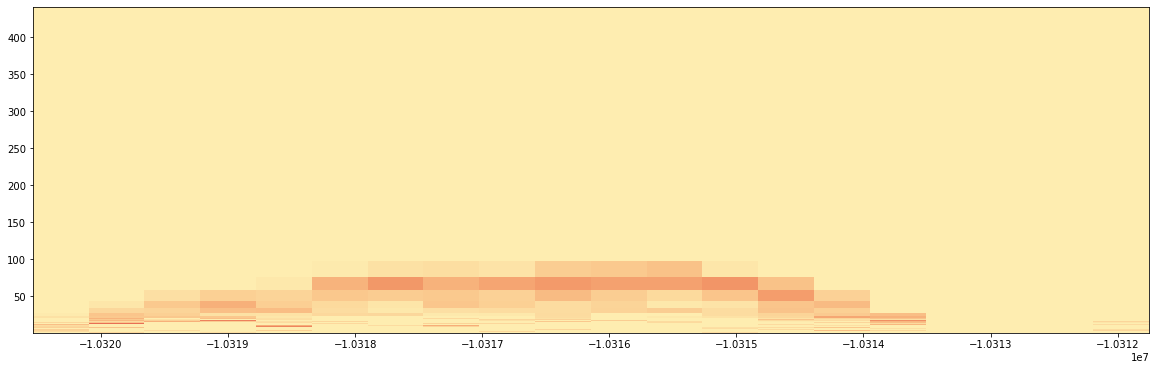

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(20, 6))

    
lons = mydata.final_lon[(mydata.final_section==4)]
lats = mydata.final_lat[(mydata.final_section==4)]

xs, ys = np.meshgrid(np.array(t_distE), np.array(t_depths))

dist = lons/m2lonE
depths = depthf(mydata.final_z[(mydata.final_section==4)]-1.)[0]
transports = mydata.final_transp[(mydata.final_section==4)]/360

vmax = .1/sum(transports)

c, xedge, yedge, im = ax.hist2d(dist, 
                            depths,
                            weights=transports,
                            bins=[np.array(t_distE[lonWs[2]:lonEs[2]]), t_depths], cmap=cm.matter, vmax = vmax, density=True, zorder=1) 
    
salinity = 0.5*(np.ma.array(xr.open_dataset(salfile).vosaline[0, :, igrid],
            mask=1-tmask[:, igrid]) +
            np.ma.array(xr.open_dataset(salfile).vosaline[0, :, igrid+1],
            mask=1-tmask[:, igrid+1]))
CS = ax.contour(xs, ys, salinity,  [29, 30, 30.2, 30.4, 30.6, 30.8, 31, 31.2, 31.4], colors='g', zorder = 2, extent = (t_distE[lonWs[2]],t_distE[lonEs[2]]))

cb1 = fig.colorbar(im, ax=ax) 
cb1.set_ticks([0, vmax])
cb1.set_ticklabels([0, np.round(((vmax * sum(transports)).values),1)]) 
cb1.set_label('m s$^{-1}$', labelpad=-20)

# ax.add_collection(pcE)
# ax.add_collection(pcW)
# ax.add_collection(pcM)

ax.invert_yaxis()
ax.set_xticks(np.linspace(t_distW[lonWs[0]+1], t_distE[lonEs[2]-1], 5))
ax.set_xticklabels(np.round(np.linspace(t_lonsW[lonWs[0]+1], t_lonsE[lonEs[2]-1], 5),2))
ax.set_xlim((t_distW[lonWs[0]], t_distE[lonEs[2]]))
ax.set_ylim((300, 0))
# ax.set_title(str(title))
mydata.close()

In [8]:
t_lonsE[lonEs[2]-1]

<xarray.DataArray 'glamt' ()>
array(-122.73462, dtype=float32)
Attributes:
    standard_name:  glamt
    long_name:      longitude of T-grid points
    units:          degrees_east

# March
## Backwards run (source water, going from strait in title to the JDF)

In [7]:
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/jordan_manydays/backward_31mar19/ariane_positions_quantitative.nc'
salfile = '/results2/SalishSea/nowcast-green.201905/15mar19/SalishSea_1d_20190315_20190315_grid_T.nc'
mydata = xr.open_dataset(file)

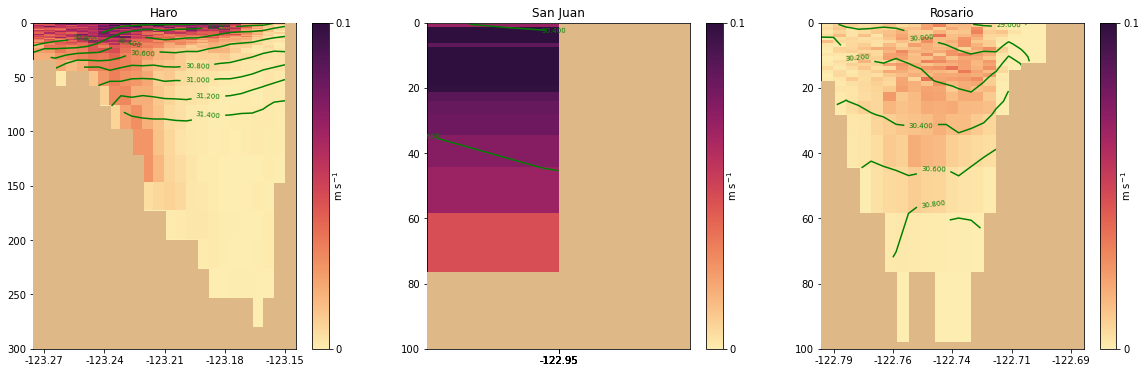

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))
tranCS(haro[0], haro[1], haro[2], haro[3], haro[4], axs[0], "Haro")
tranCS(sanjuan[0], sanjuan[1], sanjuan[2], sanjuan[3], sanjuan[4], axs[1], "San Juan")
tranCS(rosario[0], rosario[1], rosario[2], rosario[3], rosario[4], axs[2], "Rosario")

## Forwards run (from JDF to these straits)

In [6]:
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/jordan_manydays/forward_01mar19/ariane_positions_quantitative.nc'
salfile = '/results2/SalishSea/nowcast-green.201905/15mar19/SalishSea_1d_20190315_20190315_grid_T.nc'
mydata = xr.open_dataset(file)

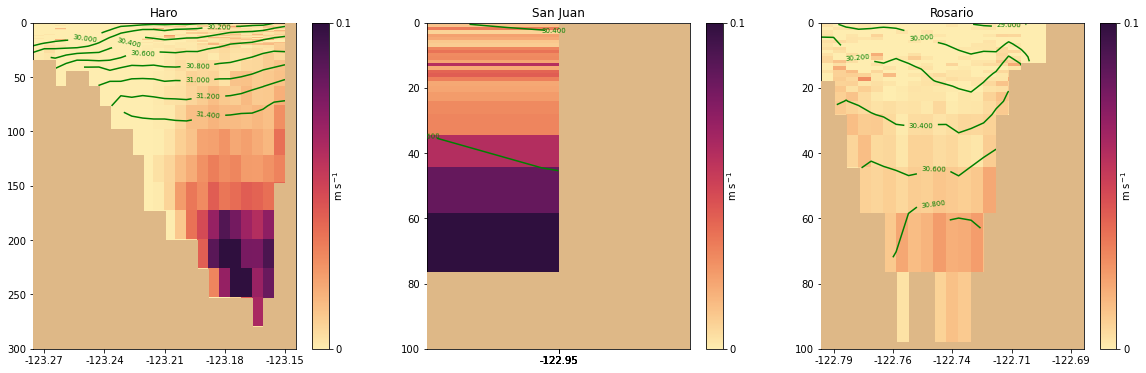

In [7]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))
tranCS(haro[0], haro[1], haro[2], haro[3], haro[4], axs[0], "Haro")
tranCS(sanjuan[0], sanjuan[1], sanjuan[2], sanjuan[3], sanjuan[4], axs[1], "San Juan")
tranCS(rosario[0], rosario[1], rosario[2], rosario[3], rosario[4], axs[2], "Rosario")

### forwards run 15 days

In [11]:
# file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/RunLengthTest/forward_01mar19_15d/ariane_positions_quantitative.nc'
# salfile = '/results2/SalishSea/nowcast-green.201905/15mar19/SalishSea_1d_20190315_20190315_grid_T.nc'
# mydata = xr.open_dataset(file)

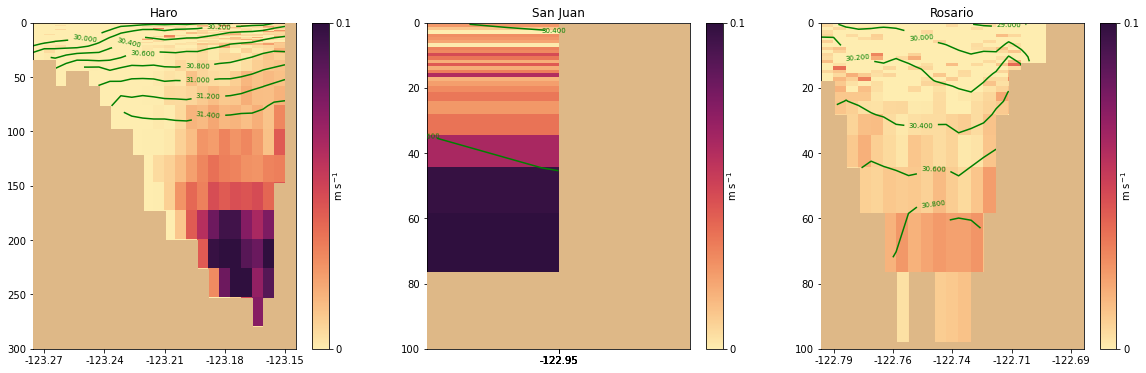

In [12]:
# fig, axs = plt.subplots(1, 3, figsize=(20, 6))
# tranCS(haro[0], haro[1], haro[2], haro[3], haro[4], axs[0], "Haro")
# tranCS(sanjuan[0], sanjuan[1], sanjuan[2], sanjuan[3], sanjuan[4], axs[1], "San Juan")
# tranCS(rosario[0], rosario[1], rosario[2], rosario[3], rosario[4], axs[2], "Rosario")
# #note, according to the stat.txt files the 15 run shoudla actually have more flow through each of these straits

### forwards run 2 months

In [13]:
# file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/RunLengthTest/forward_01mar19_2mo/ariane_positions_quantitative.nc'
# salfile = '/results2/SalishSea/nowcast-green.201905/15mar19/SalishSea_1d_20190315_20190315_grid_T.nc'
# mydata = xr.open_dataset(file)

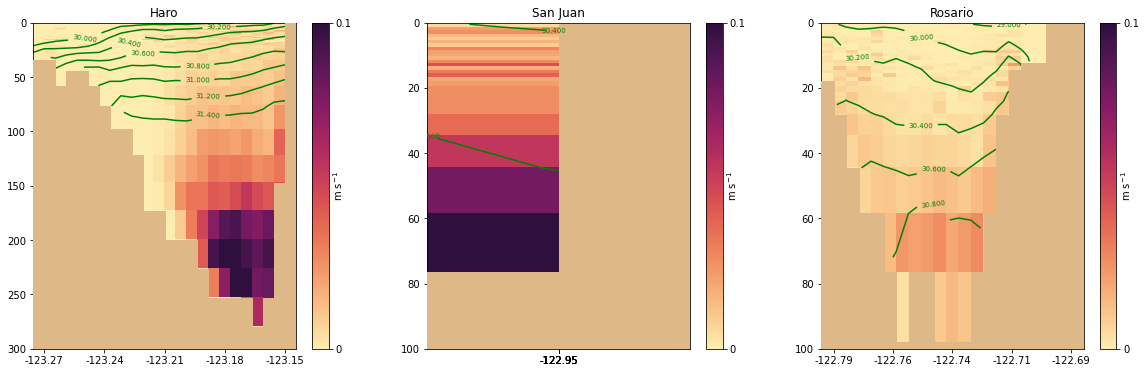

In [14]:
# fig, axs = plt.subplots(1, 3, figsize=(20, 6))
# tranCS(haro[0], haro[1], haro[2], haro[3], haro[4], axs[0], "Haro")
# tranCS(sanjuan[0], sanjuan[1], sanjuan[2], sanjuan[3], sanjuan[4], axs[1], "San Juan")
# tranCS(rosario[0], rosario[1], rosario[2], rosario[3], rosario[4], axs[2], "Rosario")
#note, the 2 month run should have the smallest transport through Haro, the smallest through San Juan, and the middle through Rosario

# June
## Backwards run (source water, going from strait in title to the JDF)

In [15]:
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/jordan_manydays/backward_01jul19/ariane_positions_quantitative.nc'
salfile = '/results2/SalishSea/nowcast-green.201905/15jun19/SalishSea_1d_20190615_20190615_grid_T.nc'
mydata = xr.open_dataset(file)

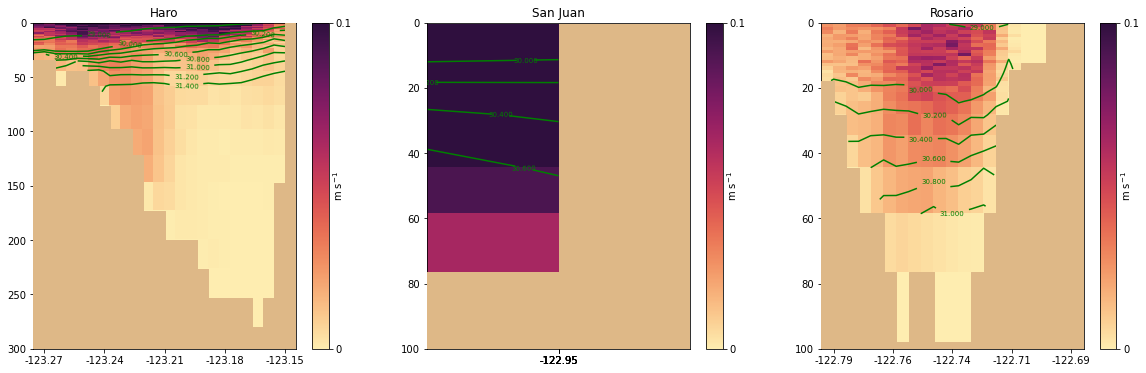

In [16]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))
tranCS(haro[0], haro[1], haro[2], haro[3], haro[4], axs[0], "Haro")
tranCS(sanjuan[0], sanjuan[1], sanjuan[2], sanjuan[3], sanjuan[4], axs[1], "San Juan")
tranCS(rosario[0], rosario[1], rosario[2], rosario[3], rosario[4], axs[2], "Rosario")

## Forwards run (from JDF to these straits)

In [17]:
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/jordan_manydays/forward_01jun19/ariane_positions_quantitative.nc'
salfile = '/results2/SalishSea/nowcast-green.201905/15jun19/SalishSea_1d_20190615_20190615_grid_T.nc'
mydata = xr.open_dataset(file)

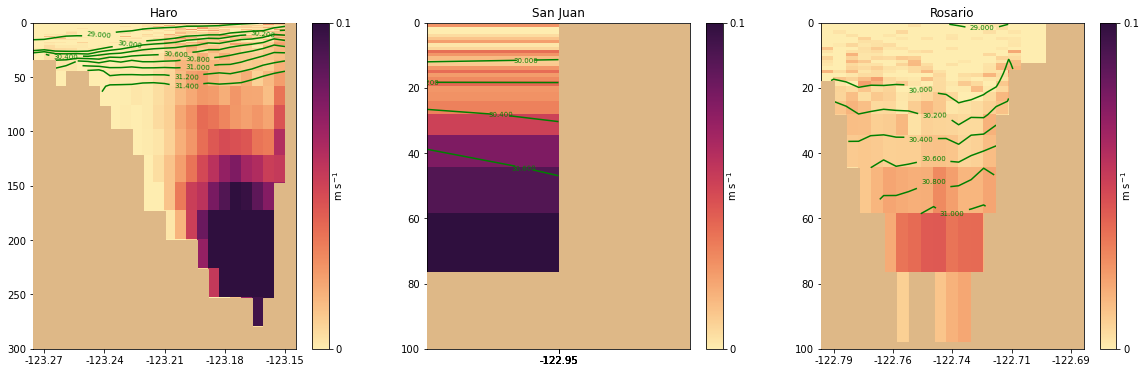

In [18]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))
tranCS(haro[0], haro[1], haro[2], haro[3], haro[4], axs[0], "Haro")
tranCS(sanjuan[0], sanjuan[1], sanjuan[2], sanjuan[3], sanjuan[4], axs[1], "San Juan")
tranCS(rosario[0], rosario[1], rosario[2], rosario[3], rosario[4], axs[2], "Rosario")

# September
## Backwards run (source water, going from strait in title to the JDF)

In [19]:
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/jordan_manydays/backward_01oct19/ariane_positions_quantitative.nc'
salfile = '/results2/SalishSea/nowcast-green.201905/15sep19/SalishSea_1d_20190915_20190915_grid_T.nc'
mydata = xr.open_dataset(file)

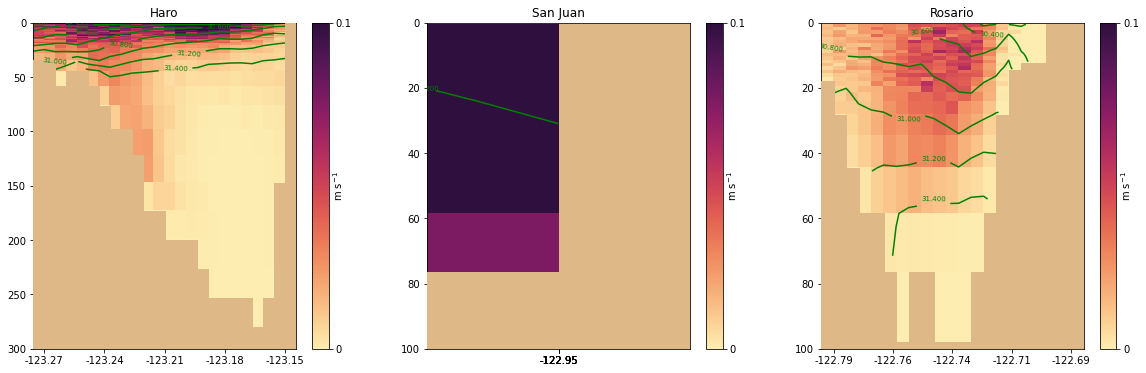

In [20]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))
tranCS(haro[0], haro[1], haro[2], haro[3], haro[4], axs[0], "Haro")
tranCS(sanjuan[0], sanjuan[1], sanjuan[2], sanjuan[3], sanjuan[4], axs[1], "San Juan")
tranCS(rosario[0], rosario[1], rosario[2], rosario[3], rosario[4], axs[2], "Rosario")

## Forwards run (from JDF to these straits)

In [21]:
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/jordan_manydays/forward_01sep19/ariane_positions_quantitative.nc'
salfile = '/results2/SalishSea/nowcast-green.201905/15sep19/SalishSea_1d_20190915_20190915_grid_T.nc'
mydata = xr.open_dataset(file)

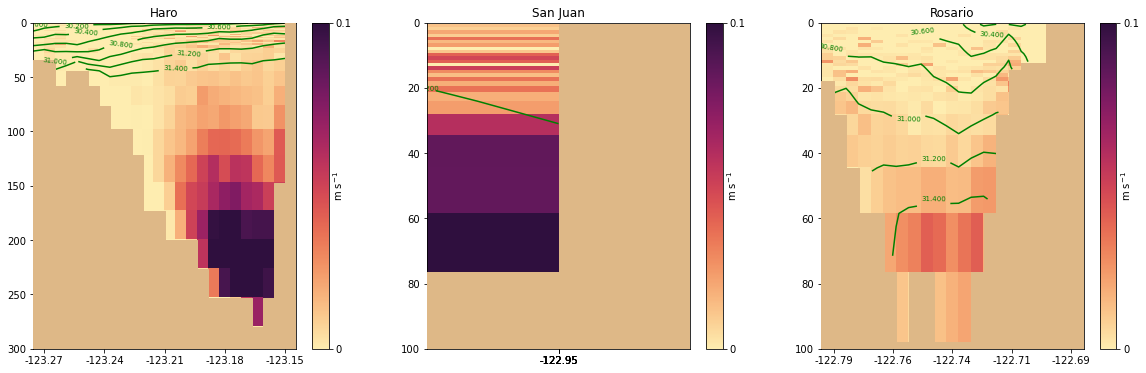

In [22]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))
tranCS(haro[0], haro[1], haro[2], haro[3], haro[4], axs[0], "Haro")
tranCS(sanjuan[0], sanjuan[1], sanjuan[2], sanjuan[3], sanjuan[4], axs[1], "San Juan")
tranCS(rosario[0], rosario[1], rosario[2], rosario[3], rosario[4], axs[2], "Rosario")

# December
## Backwards run (source water, going from strait in title to the JDF)

In [23]:
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/jordan_manydays/backward_31dec19/ariane_positions_quantitative.nc'
salfile = '/results2/SalishSea/nowcast-green.201905/15dec19/SalishSea_1d_20191215_20191215_grid_T.nc'
mydata = xr.open_dataset(file)

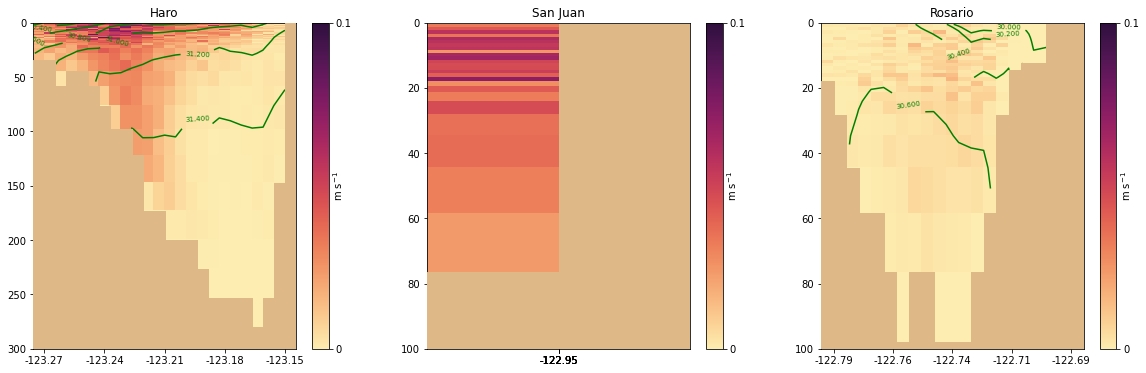

In [24]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))
tranCS(haro[0], haro[1], haro[2], haro[3], haro[4], axs[0], "Haro")
tranCS(sanjuan[0], sanjuan[1], sanjuan[2], sanjuan[3], sanjuan[4], axs[1], "San Juan")
tranCS(rosario[0], rosario[1], rosario[2], rosario[3], rosario[4], axs[2], "Rosario")

## Forwards run (from JDF to these straits)

In [25]:
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/jordan_manydays/forward_01dec19/ariane_positions_quantitative.nc'
salfile = '/results2/SalishSea/nowcast-green.201905/15dec19/SalishSea_1d_20191215_20191215_grid_T.nc'
mydata = xr.open_dataset(file)

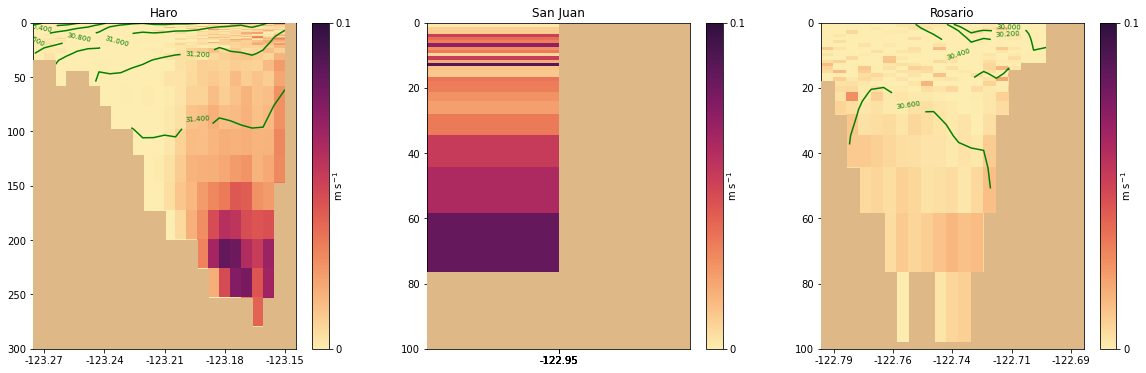

In [26]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))
tranCS(haro[0], haro[1], haro[2], haro[3], haro[4], axs[0], "Haro")
tranCS(sanjuan[0], sanjuan[1], sanjuan[2], sanjuan[3], sanjuan[4], axs[1], "San Juan")
tranCS(rosario[0], rosario[1], rosario[2], rosario[3], rosario[4], axs[2], "Rosario")

# One year 
### Forward

In [27]:
# file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/jordan_manydays/forward1yr_01jan19/ariane_positions_quantitative.nc'
# salfile = '/results2/SalishSea/nowcast-green.201905/15dec19/SalishSea_1d_20191215_20191215_grid_T.nc'
# mydata = xr.open_dataset(file)
# time1 = mydata.init_t[0]

In [28]:
# fig, axs = plt.subplots(1, 3, figsize=(20, 6))
# tranCS(haro[0], haro[1], haro[2], haro[3], haro[4], axs[0], "Haro")
# tranCS(sanjuan[0], sanjuan[1], sanjuan[2], sanjuan[3], sanjuan[4], axs[1], "San Juan")
# tranCS(rosario[0], rosario[1], rosario[2], rosario[3], rosario[4], axs[2], "Rosario")

### Backward

In [29]:
# file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/jordan_manydays/backward1yr_31dec19/ariane_positions_quantitative.nc'
# salfile = '/results2/SalishSea/nowcast-green.201905/15dec19/SalishSea_1d_20191215_20191215_grid_T.nc'
# mydata = xr.open_dataset(file)
# time1 = mydata.init_t[0]

In [30]:
# fig, axs = plt.subplots(1, 3, figsize=(20, 6))
# tranCS(haro[0], haro[1], haro[2], haro[3], haro[4], axs[0], "Haro")
# tranCS(sanjuan[0], sanjuan[1], sanjuan[2], sanjuan[3], sanjuan[4], axs[1], "San Juan")
# tranCS(rosario[0], rosario[1], rosario[2], rosario[3], rosario[4], axs[2], "Rosario")